# Cabecera

## Ejercicio 2 — Actividad Tratamiento de datos de viento
**Asignatura:** Metodología de la I+d y Documentación Científica  
**Autor:** Santiago Santana Martínez  
**Fecha:** 14 de enero de 2026  
**Entorno:** Jupyter Notebook (Python 3)

---

## Configuración del Entorno

### Librerías Requeridas

Este análisis utiliza las siguientes librerías de Python:
- **numpy, pandas:** Manipulación y análisis numérico de datos
- **scipy.stats (weibull_min):** Distribuciones estadísticas y ajuste paramétrico
- **matplotlib.pyplot:** Visualización de datos
- **windrose** (opcional): Rosa de vientos estandarizada

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Intento de importar windrose (librería opcional para rosa de vientos estándar)
try:
    from windrose import WindroseAxes
    HAS_WINDROSE = True
except ImportError:
    HAS_WINDROSE = False

# Configuración de matplotlib
plt.rcParams["figure.figsize"] = (13, 6)
plt.rcParams["font.size"] = 10

print("- Entorno configurado correctamente")
print(f"- windrose disponible: {'Sí' if HAS_WINDROSE else 'No'}")

- Entorno configurado correctamente
- windrose disponible: Sí


## 2. Carga e Inspección de Datos en Bruto

### 2.1 Detección y Carga de Ficheros

Se realiza una búsqueda automática de ficheros con extensión `.xls` en el directorio de trabajo. Cada fichero se carga en memoria sin ningún procesamiento previo, preservando la estructura original de los datos tal como existen en las fuentes.

In [2]:
DATA_DIR = "."

xls_files = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith(".xls")])

print("\n" + "="*90)
print("DETECCIÓN DE FICHEROS DE DATOS")
print("="*90)
print(f"\nDirectorio: {os.path.abspath(DATA_DIR)}")
print(f"Ficheros .xls detectados: {len(xls_files)}\n")

if xls_files:
    for i, f in enumerate(xls_files, 1):
        file_path = os.path.join(DATA_DIR, f)
        file_size = os.path.getsize(file_path) / 1024  # en KB
        print(f"  {i}. {f:<50} ({file_size:.1f} KB)")
else:
    print("No se encontraron ficheros .xls en el directorio actual.")
    print("Asegúrate de que los archivos estén disponibles en el mismo directorio.")


DETECCIÓN DE FICHEROS DE DATOS

Directorio: c:\Users\santu\Desktop\Documentos ULPGC\Master\Asignaturas\Primer Semestre\MID\Bloque 3\MID_Bloque_3_Trabajo\Actividad_Tratamiento_de_datos_de_viento
Ficheros .xls detectados: 3

  1. 2023_01.xls                                        (178.5 KB)
  2. 2024_01.xls                                        (174.5 KB)
  3. 2025_01.xls                                        (174.5 KB)



### 2.2 Inspección Visual de la Estructura

**Objetivo:** Visualizar la estructura bruta de los datos sin transformación alguna para identificar anomalías, valores faltantes, y esquema de columnas. Esta etapa es crítica para comprender la calidad de los datos y planificar estrategias de estandarización.

Información a inspeccionar:
- Dimensiones (número de filas y columnas)
- Primeras y últimas observaciones (continuidad temporal)
- Nombres y tipos de datos de las columnas
- Conteo de valores faltantes (NaN) por columna
- Estadísticas descriptivas de variables numéricas

In [3]:
print("\n" + "="*90)
print("INSPECCIÓN VISUAL DE ESTRUCTURA DE DATOS EN BRUTO")
print("="*90)
print("\nCargando ficheros...\n")

def data_info(name, df):
    print("="*90)
    print(f"\nDETALLES DEL FICHERO: {name}")
    print("="*90)
    print(f"\n  Dimensiones: {df.shape[0]} × {df.shape[1]}")
    print(f"\n  PRIMERAS 10 FILAS:\n")
    display(df.head(10))
    
    print(f"\n\n  ÚLTIMAS 5 FILAS:\n")
    display(df.tail(5))
    
    print(f"\n\n  ESQUEMA DE COLUMNAS:")
    print(f"  {'Columna':<30} {'Tipo de Dato':<15}")
    print(f"  {'-'*45}")
    for col in df.columns:
        print(f"  {str(col):<30} {str(df[col].dtype):<15}")
    
    print(f"\n\n  CONTEO DE VALORES FALTANTES (NaN):")
    print(f"  {'Columna':<30} {'Faltantes':<10} {'%':<8}")
    print(f"  {'-'*48}")
    for col in df.columns:
        n_na = df[col].isna().sum()
        pct = 100 * n_na / len(df)
        print(f"  {str(col):<30} {n_na:<10} {pct:.1f}%")
    
    print(f"\n\n  ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS:\n")
    display(df.describe())

datasets = {}
for f in xls_files:
    path = os.path.join(DATA_DIR, f)
    try:
        df = pd.read_excel(path, engine="xlrd")
        datasets[f] = df
        print(f"Cargado correctamente: {f}: {df.shape[0]:5d} filas × {df.shape[1]:2d} columnas")
    except Exception as e:
        print(f"Error al cargar {f}: {e}")

if not datasets:
    print("\nNo se pudieron cargar ficheros. Verifica que xlrd esté instalado.")
    print("  Instala con: pip install xlrd")
else:
    print(f"\nTotal de ficheros cargados: {len(datasets)}\n")
    
    # Detalles de los ficheros
    for file_name, file_df in datasets.items():
        data_info(file_name, file_df)


INSPECCIÓN VISUAL DE ESTRUCTURA DE DATOS EN BRUTO

Cargando ficheros...

Cargado correctamente: 2023_01.xls:   744 filas × 15 columnas
Cargado correctamente: 2024_01.xls:   719 filas × 15 columnas
Cargado correctamente: 2025_01.xls:   720 filas × 15 columnas

Total de ficheros cargados: 3


DETALLES DEL FICHERO: 2023_01.xls

  Dimensiones: 744 × 15

  PRIMERAS 10 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,31/01/2023,23Z,15.0,78%,1022.0 Hpa,340º (N),13.0,-,-,-,-,-,-,-,Precipitacion
1,31/01/2023,22Z,14.5,83%,1021.6 Hpa,340º (N),16.6,-,-,-,-,-,-,-,Precipitacion
2,31/01/2023,21Z,15.4,79%,1021.5 Hpa,320º (NW),16.6,6/8,6/8 CU/ST,N/D,N/D,-,-,-,"Nuboso, lluvia intermitente"
3,31/01/2023,20Z,15.8,64%,1020.8 Hpa,340º (N),13.0,-,-,-,-,-,-,-,-
4,31/01/2023,19Z,16.8,59%,1020.8 Hpa,360º (N),22.3,-,-,-,-,-,-,-,-
5,31/01/2023,18Z,17.7,55%,1020.5 Hpa,360º (N),27.7,2/8,2/8 SC,-,-,-,20.3,-,Algunas nubes
6,31/01/2023,17Z,18.4,51%,1020.5 Hpa,10º (N),29.5,-,-,-,-,-,-,-,-
7,31/01/2023,16Z,18.1,56%,1020.6 Hpa,20º (N),25.9,-,-,-,-,-,-,-,-
8,31/01/2023,15Z,18.2,56%,1020.8 Hpa,20º (N),22.3,4/8,4/8 CU/ST,-,-,-,-,-,Nubes dispersas
9,31/01/2023,14Z,18.2,60%,1021.2 Hpa,30º (NE),22.3,-,-,-,-,-,-,-,-




  ÚLTIMAS 5 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
739,01/01/2023,04Z,17.5,88%,1021.7 Hpa,250º (W),7.6,-,-,-,-,-,-,-,-
740,01/01/2023,03Z,17.2,86%,1022.2 Hpa,0º (N),0.0,2/8,2/8 SC,-,-,-,-,-,Algunas nubes
741,01/01/2023,02Z,16.7,84%,1022.4 Hpa,240º (SW),7.6,-,-,-,-,-,-,-,-
742,01/01/2023,01Z,16.5,84%,1022.6 Hpa,160º (S),3.6,-,-,-,-,-,-,-,-
743,01/01/2023,00Z,17.7,85%,1023.1 Hpa,210º (SW),7.6,0/8,-,-,-,-,-,-,Despejado




  ESQUEMA DE COLUMNAS:
  Columna                        Tipo de Dato   
  ---------------------------------------------
  Fecha                          object         
  Hora UTC                       object         
  Temp. (ºC)                     float64        
  H.Rel (%)                      object         
  Presion/ Geopot.               object         
  Dir. vi.                       object         
  Vel. vi. (Km/h)                float64        
  Nub.                           object         
  Nubes bajas                    object         
  Nubes medias                   object         
  Nubes altas                    object         
  Prec. (mm)                     object         
  T. max (ºC)                    object         
  T. min (ºC)                    object         
  Situacion                      object         


  CONTEO DE VALORES FALTANTES (NaN):
  Columna                        Faltantes  %       
  ------------------------------------------------


,Temp. (ºC),Vel. vi. (Km/h)
count,744.000000,744.000000
mean,18.679301,23.796237
std,1.891705,9.302421
min,13.800000,0.000000
25%,17.400000,16.600000
50%,18.400000,22.300000
75%,20.000000,31.300000
max,24.000000,50.000000



DETALLES DEL FICHERO: 2024_01.xls

  Dimensiones: 719 × 15

  PRIMERAS 10 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,30/01/2024,23Z,17.6,35%,1023.7 Hpa,360º (N),13.0,-,-,-,-,-,-,-,-
1,30/01/2024,22Z,18.3,33%,1023.7 Hpa,340º (N),11.2,-,-,-,-,-,-,-,-
2,30/01/2024,21Z,19.1,58%,1023.5 Hpa,350º (N),5.4,0/8,-,-,-,-,-,-,Despejado
3,30/01/2024,20Z,19.9,63%,1022.9 Hpa,330º (NW),7.6,-,-,-,-,-,-,-,-
4,30/01/2024,19Z,21.2,61%,1022.4 Hpa,50º (NE),5.4,-,-,-,-,-,-,-,-
5,30/01/2024,18Z,22.2,56%,1022.5 Hpa,80º (E),7.6,1/8,-,-,CS,-,26.9,-,Algunas nubes
6,30/01/2024,17Z,23.4,45%,1022.5 Hpa,100º (E),9.4,-,-,-,-,-,-,-,-
7,30/01/2024,16Z,24.5,34%,1022.5 Hpa,100º (E),7.6,-,-,-,-,-,-,-,-
8,30/01/2024,15Z,25.3,23%,1022.5 Hpa,100º (E),5.4,1/8,-,-,CS,-,-,-,Algunas nubes
9,30/01/2024,14Z,26.6,18%,1023.1 Hpa,120º (SE),5.4,-,-,-,-,-,-,-,-




  ÚLTIMAS 5 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
714,01/01/2024,04Z,16.2,58%,1019.4 Hpa,300º (NW),7.6,-,-,-,-,-,-,-,-
715,01/01/2024,03Z,16.4,62%,1019.6 Hpa,290º (W),5.4,0/8,-,-,-,-,-,-,Despejado
716,01/01/2024,02Z,17.2,63%,1020.1 Hpa,300º (NW),7.6,-,-,-,-,-,-,-,-
717,01/01/2024,01Z,17.3,58%,1020.2 Hpa,320º (NW),9.4,-,-,-,-,-,-,-,-
718,01/01/2024,00Z,17.3,62%,1020.5 Hpa,320º (NW),7.4,0/8,-,-,-,-,-,-,Despejado




  ESQUEMA DE COLUMNAS:
  Columna                        Tipo de Dato   
  ---------------------------------------------
  Fecha                          object         
  Hora UTC                       object         
  Temp. (ºC)                     float64        
  H.Rel (%)                      object         
  Presion/ Geopot.               object         
  Dir. vi.                       object         
  Vel. vi. (Km/h)                float64        
  Nub.                           object         
  Nubes bajas                    object         
  Nubes medias                   object         
  Nubes altas                    object         
  Prec. (mm)                     object         
  T. max (ºC)                    object         
  T. min (ºC)                    object         
  Situacion                      object         


  CONTEO DE VALORES FALTANTES (NaN):
  Columna                        Faltantes  %       
  ------------------------------------------------


,Temp. (ºC),Vel. vi. (Km/h)
count,714.000000,714.000000
mean,20.363165,15.381933
std,2.646727,9.505128
min,14.400000,0.000000
25%,18.400000,9.400000
50%,19.900000,13.000000
75%,21.900000,18.400000
max,30.700000,50.000000



DETALLES DEL FICHERO: 2025_01.xls

  Dimensiones: 720 × 15

  PRIMERAS 10 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,30/01/2025,23:00,18.9,57%,1030.7 Hpa,360º (N),31.3,-,-,-,-,-,-,-,-
1,30/01/2025,22:00,19.1,53%,1030.7 Hpa,20º (N),44.3,-,-,-,-,-,-,-,-
2,30/01/2025,21:00,19.2,55%,1030.1 Hpa,360º (N),37.1,6/8,6/8 Sc,N/D,N/D,-,-,-,Nuboso
3,30/01/2025,20:00,19.0,54%,1030.2 Hpa,10º (N),50.0,-,-,-,-,-,-,-,-
4,30/01/2025,19:00,19.6,55%,1029.7 Hpa,20º (N),53.6,-,-,-,-,-,-,-,-
5,30/01/2025,18:00,19.9,51%,1029.2 Hpa,360º (N),46.4,6/8,6/8 Sc,-,-,Ip(12h),22.5,-,Nuboso
6,30/01/2025,17:00,20.0,48%,1029.3 Hpa,10º (N),46.4,-,-,-,-,-,-,-,-
7,30/01/2025,16:00,20.3,55%,1029.1 Hpa,10º (N),50.0,-,-,-,-,-,-,-,-
8,30/01/2025,15:00,21.1,48%,1028.8 Hpa,20º (N),53.6,5/8,5/8 Sc,-,-,-,-,-,Nuboso
9,30/01/2025,14:00,21.9,46%,1029.2 Hpa,20º (N),59.4,-,-,-,-,-,-,-,-




  ÚLTIMAS 5 FILAS:



,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
715,01/01/2025,04:00,16.8,68%,1024.2 Hpa,290º (W),13.0,-,-,-,-,-,-,-,-
716,01/01/2025,03:00,16.9,67%,1024.4 Hpa,300º (NW),13.0,1/8,1/8 Sc,-,-,-,-,-,Algunas nubes
717,01/01/2025,02:00,16.9,68%,1024.6 Hpa,310º (NW),13.0,-,-,-,-,-,-,-,-
718,01/01/2025,01:00,17.1,66%,1025.1 Hpa,310º (NW),13.0,-,-,-,-,-,-,-,-
719,01/01/2025,00:00,17.5,66%,1025.4 Hpa,310º (NW),13.0,1/8,1/8 Sc,-,-,-,-,-,Algunas nubes




  ESQUEMA DE COLUMNAS:
  Columna                        Tipo de Dato   
  ---------------------------------------------
  Fecha                          object         
  Hora UTC                       object         
  Temp. (ºC)                     float64        
  H.Rel (%)                      object         
  Presion/ Geopot.               object         
  Dir. vi.                       object         
  Vel. vi. (Km/h)                float64        
  Nub.                           object         
  Nubes bajas                    object         
  Nubes medias                   object         
  Nubes altas                    object         
  Prec. (mm)                     object         
  T. max (ºC)                    object         
  T. min (ºC)                    object         
  Situacion                      object         


  CONTEO DE VALORES FALTANTES (NaN):
  Columna                        Faltantes  %       
  ------------------------------------------------


,Temp. (ºC),Vel. vi. (Km/h)
count,720.000000,720.000000
mean,19.486806,20.335278
std,2.134355,11.601336
min,14.500000,0.000000
25%,17.900000,11.200000
50%,19.300000,18.400000
75%,21.225000,29.500000
max,24.900000,59.400000


### 2.3 Estandarización de Estructura de Datos

**Objetivo:** Crear un esquema de datos uniforme a partir de ficheros potencialmente heterogéneos.

**Justificación:** Los datos de tres años diferentes pueden poseer nombres de columnas inconsistentes o estructuras ligeramente distintas. Para permitir un análisis comparativo consistente, se implementa **detección automática de columnas críticas** basada en búsqueda de palabras clave (case-insensitive):

- **Columna temporal:** búsqueda de palabras clave ("fecha", "date", "datetime", "hora", "time")
- **Columna de velocidad:** búsqueda de ("vel", "speed", "viento", "wind speed")
- **Columna de dirección:** búsqueda de ("dir", "direccion", "wind dir")

La estandarización genera un DataFrame unificado con tres columnas: `timestamp`, `wind_speed`, `wind_dir`, ordenado cronológicamente. Este proceso conserva la integridad de los datos mientras habilita operaciones analíticas consistentes.

In [4]:
def find_column(df, keywords):
    cols = list(df.columns)
    cols_lower = [str(c).lower() for c in cols]
    for kw in keywords:
        for i, c_low in enumerate(cols_lower):
            if kw.lower() in c_low:
                return cols[i]
    return None

# Mapa de conversión Cardinal -> Grados (definir aquí para usar en estandarización)
CARDINAL_TO_DEG = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

# Mapa inverso: Grados -> Cardinal (para conversión inversa)
DEG_TO_CARDINAL = {v: k for k, v in CARDINAL_TO_DEG.items()}

def convert_direction(series):
    """
    Convierte dirección de cualquier formato a (grados normalizados, dirección cardinal).
    Soporta: "210º (SW)", números puros (210), o cardinales (SW, N, NE, etc.).
    Retorna tupla: (grados_normalizados, dirección_cardinal_16sectores)
    """
    def process_value(val):
        if pd.isna(val):
            return np.nan, np.nan
        
        val_str = str(val).strip()
        
        # 1. Intentar extraer número de formato "210º (SW)"
        import re
        match = re.search(r'(\d+)', val_str)
        if match:
            deg = int(match.group(1)) % 360
        else:
            # 2. Intentar conversión numérica directa
            try:
                deg = int(float(val_str)) % 360
            except (ValueError, TypeError):
                # 3. Intentar búsqueda de cardinal en texto
                val_upper = val_str.upper()
                deg = None
                for cardinal, d in CARDINAL_TO_DEG.items():
                    if cardinal in val_upper:
                        deg = d
                        break
                if deg is None:
                    return np.nan, np.nan
        
        # Encontrar cardinal más cercano (de 16 sectores)
        sector_size = 22.5
        sector_idx = round(deg / sector_size) % 16
        sector_labels = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
                         "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
        cardinal = sector_labels[sector_idx]
        
        return deg, cardinal
    
    result = series.apply(process_value)
    return result

def standardize_dataframe(df_raw, file_name=""):
    df = df_raw.copy()
    
    # 1. Detectar columna de fecha/hora
    time_col = find_column(df, ["fecha", "date", "datetime", "time"])
    date_col = find_column(df, ["fecha", "date"])
    hour_col = find_column(df, ["hora", "hour", "time"])
    
    # Construir timestamp
    if date_col is not None and hour_col is not None and date_col != hour_col:
        # Combinar fecha + hora
        date_str = df[date_col].astype(str).str.strip()
        hour_str = df[hour_col].astype(str).str.strip()
        ts = date_str + " " + hour_str
        df["timestamp"] = pd.to_datetime(ts, errors="coerce", dayfirst=True)
    elif time_col is not None:
        df["timestamp"] = pd.to_datetime(df[time_col], errors="coerce", dayfirst=True)
    else:
        raise ValueError(f"ERROR en {file_name}: No se pudo detectar columna de fecha/hora. Revisa nombres.")
    
    # 2. Detectar columna de velocidad
    speed_col = find_column(df, ["vel", "speed", "viento", "wind"])
    if speed_col is None:
        # Fallback: primera columna numérica
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            speed_col = numeric_cols[0]
        else:
            raise ValueError(f"ERROR en {file_name}: No se pudo detectar columna de velocidad.")
    df["wind_speed"] = pd.to_numeric(df[speed_col], errors="coerce")
    
    # 3. Detectar columna de dirección
    dir_col = find_column(df, ["dir", "direccion", "direction", "wind dir", "wind_dir", "rumbo"])
    if dir_col is not None:
        df["wind_dir"] = df[dir_col]
    else:
        # Fallback: buscar columnas no utilizadas (numéricas o de texto)
        used_cols = {date_col, hour_col, speed_col, time_col}
        unused_cols = [c for c in df.columns if c not in used_cols]
        if unused_cols:
            # Usar la primera columna no utilizada
            dir_col = unused_cols[0]
            df["wind_dir"] = df[dir_col]
        else:
            df["wind_dir"] = np.nan
    
    # 4. Convertir dirección a grados y cardinal
    direction_conversions = convert_direction(df["wind_dir"])
    df["dir_deg"] = direction_conversions.apply(lambda x: x[0])
    df["dir_cardinal"] = direction_conversions.apply(lambda x: x[1])
    
    # Crear DataFrame estandarizado
    out = df[["timestamp", "wind_speed", "wind_dir", "dir_deg", "dir_cardinal"]].copy()
    out = out.sort_values("timestamp").reset_index(drop=True)
    
    # Calcular % válido de velocidades
    n_valid = out["wind_speed"].notna().sum()
    pct_valid = 100 * n_valid / len(out)
    
    metadata = {
        "file_name": file_name,
        "date_col": date_col,
        "hour_col": hour_col,
        "speed_col": speed_col,
        "dir_col": dir_col,
        "time_col": time_col,
        "n_records": len(out),
        "n_valid_speed": n_valid,
        "pct_valid_speed": pct_valid,
        "n_valid_dir": out["wind_dir"].notna().sum()
    }

    display(out.head(3))
    
    return out, metadata

# Aplicar estandarización a todos los ficheros
print("\n" + "="*90)
print("ESTANDARIZACIÓN DE ESTRUCTURA DE DATOS")
print("="*90 + "\n")

std_datasets = {}
metadata_all = {}

for name, df in datasets.items():
    try:
        df_std, meta = standardize_dataframe(df, name)
        std_datasets[name] = df_std
        metadata_all[name] = meta
        
        print(f"- {name}")
        print(f"    Columnas detectadas:")
        print(f"      Fecha: {meta['date_col']}, Hora: {meta['hour_col']}")
        print(f"      Velocidad: {meta['speed_col']}")
        print(f"      Dirección: {meta['dir_col']}")
        print(f"    Registros: {meta['n_records']} | Velocidades válidas: {meta['n_valid_speed']}/{meta['n_records']} ({meta['pct_valid_speed']:.1f}%)")
        print(f"    Direcciones válidas: {meta['n_valid_dir']}/{meta['n_records']} ({100*meta['n_valid_dir']/meta['n_records']:.1f}%)")
        
        # Debug: mostrar primeros valores de dirección
        print(f"    Primeros valores de wind_dir: {df_std['wind_dir'].head(5).tolist()}")
        print()
    except Exception as e:
        print(f"- {name}: {e}\n")


ESTANDARIZACIÓN DE ESTRUCTURA DE DATOS



,timestamp,wind_speed,wind_dir,dir_deg,dir_cardinal
0,2023-01-01 00:00:00+00:00,7.6,210º (SW),210,SSW
1,2023-01-01 01:00:00+00:00,3.6,160º (S),160,SSE
2,2023-01-01 02:00:00+00:00,7.6,240º (SW),240,WSW


- 2023_01.xls
    Columnas detectadas:
      Fecha: Fecha, Hora: Hora UTC
      Velocidad: Vel. vi. (Km/h)
      Dirección: Dir. vi.
    Registros: 744 | Velocidades válidas: 744/744 (100.0%)
    Direcciones válidas: 744/744 (100.0%)
    Primeros valores de wind_dir: ['210º (SW)', '160º (S)', '240º (SW)', '0º (N)', '250º (W)']



,timestamp,wind_speed,wind_dir,dir_deg,dir_cardinal
0,2024-01-01 00:00:00+00:00,7.4,320º (NW),320,NW
1,2024-01-01 01:00:00+00:00,9.4,320º (NW),320,NW
2,2024-01-01 02:00:00+00:00,7.6,300º (NW),300,WNW


- 2024_01.xls
    Columnas detectadas:
      Fecha: Fecha, Hora: Hora UTC
      Velocidad: Vel. vi. (Km/h)
      Dirección: Dir. vi.
    Registros: 719 | Velocidades válidas: 714/719 (99.3%)
    Direcciones válidas: 719/719 (100.0%)
    Primeros valores de wind_dir: ['320º (NW)', '320º (NW)', '300º (NW)', '290º (W)', '300º (NW)']



,timestamp,wind_speed,wind_dir,dir_deg,dir_cardinal
0,2025-01-01 00:00:00,13.0,310º (NW),310,NW
1,2025-01-01 01:00:00,13.0,310º (NW),310,NW
2,2025-01-01 02:00:00,13.0,310º (NW),310,NW


- 2025_01.xls
    Columnas detectadas:
      Fecha: Fecha, Hora: Hora UTC
      Velocidad: Vel. vi. (Km/h)
      Dirección: Dir. vi.
    Registros: 720 | Velocidades válidas: 720/720 (100.0%)
    Direcciones válidas: 720/720 (100.0%)
    Primeros valores de wind_dir: ['310º (NW)', '310º (NW)', '310º (NW)', '300º (NW)', '290º (W)']



## 3. Estadísticos Descriptivos

### 3.1 Cálculo de Estadísticos Fundamentales

Se calculan los estadísticos descriptivos básicos de las velocidades de viento observadas, excluyendo valores faltantes. Los estadísticos incluyen:

$$\text{Media (μ)} = \frac{1}{n}\sum_{i=1}^{n} v_i$$

$$\text{Desviación Estándar (σ)} = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n} (v_i - μ)^2}$$

$$\text{Rango:} \; v_{\min}, v_{\max}$$

Donde $v_i$ representa la velocidad de viento en la observación $i$, y $n$ es el número total de muestras válidas. Se utilizan quartiles (Q₁, mediana, Q₃) para caracterizar la distribución en percentiles estándar.

In [6]:
def compute_basic_stats(df_std):
    """Calcula estadísticos descriptivos de velocidad del viento."""
    s = df_std["wind_speed"].dropna()
    if len(s) == 0:
        return None
    return {
        "n_valid": int(s.shape[0]),
        "n_total": int(len(df_std)),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "q25": float(s.quantile(0.25)),
        "median": float(s.median()),
        "q75": float(s.quantile(0.75)),
        "max": float(s.max())
    }

print("\n" + "="*90)
print("CÁLCULO DE ESTADÍSTICOS DESCRIPTIVOS POR FICHERO")
print("="*90 + "\n")

stats_list = []
for name, df_std in std_datasets.items():
    st = compute_basic_stats(df_std)
    if st:
        st["Fichero"] = name
        stats_list.append(st)
        print(f"{name}:")
        print(f"  Media (μ):           {st['mean']:.3f} m/s")
        print(f"  Desv. Estándar (σ):  {st['std']:.3f} m/s")
        print(f"  Mínimo:              {st['min']:.3f} m/s")
        print(f"  Q₁ (25%):            {st['q25']:.3f} m/s")
        print(f"  Mediana:             {st['median']:.3f} m/s")
        print(f"  Q₃ (75%):            {st['q75']:.3f} m/s")
        print(f"  Máximo:              {st['max']:.3f} m/s")
        print(f"  Muestras válidas:    {st['n_valid']}/{st['n_total']} ({100*st['n_valid']/st['n_total']:.1f}%)\n")


CÁLCULO DE ESTADÍSTICOS DESCRIPTIVOS POR FICHERO

2023_01.xls:
  Media (μ):           23.796 m/s
  Desv. Estándar (σ):  9.302 m/s
  Mínimo:              0.000 m/s
  Q₁ (25%):            16.600 m/s
  Mediana:             22.300 m/s
  Q₃ (75%):            31.300 m/s
  Máximo:              50.000 m/s
  Muestras válidas:    744/744 (100.0%)

2024_01.xls:
  Media (μ):           15.382 m/s
  Desv. Estándar (σ):  9.505 m/s
  Mínimo:              0.000 m/s
  Q₁ (25%):            9.400 m/s
  Mediana:             13.000 m/s
  Q₃ (75%):            18.400 m/s
  Máximo:              50.000 m/s
  Muestras válidas:    714/719 (99.3%)

2025_01.xls:
  Media (μ):           20.335 m/s
  Desv. Estándar (σ):  11.601 m/s
  Mínimo:              0.000 m/s
  Q₁ (25%):            11.200 m/s
  Mediana:             18.400 m/s
  Q₃ (75%):            29.500 m/s
  Máximo:              59.400 m/s
  Muestras válidas:    720/720 (100.0%)



### 3.2 Tabla de Estadísticos Descriptivos

In [8]:
if stats_list:
    stats_df = pd.DataFrame(stats_list).set_index("Fichero")
    print("\nTABLA COMPARATIVA (todos los años):\n")
    display(stats_df[["n_valid", "mean", "std", "min", "median", "max"]].round(3))


TABLA COMPARATIVA (todos los años):



,n_valid,mean,std,min,median,max
Fichero,,,,,,
2023_01.xls,744,23.796,9.302,0.0,22.3,50.0
2024_01.xls,714,15.382,9.505,0.0,13.0,50.0
2025_01.xls,720,20.335,11.601,0.0,18.4,59.4


# 4. Iterar sobre cada fichero (año) para generar visualizaciones


ANÁLISIS TEMPORAL DE VELOCIDADES DE VIENTO

ANALIZANDO: 2023_01.xls



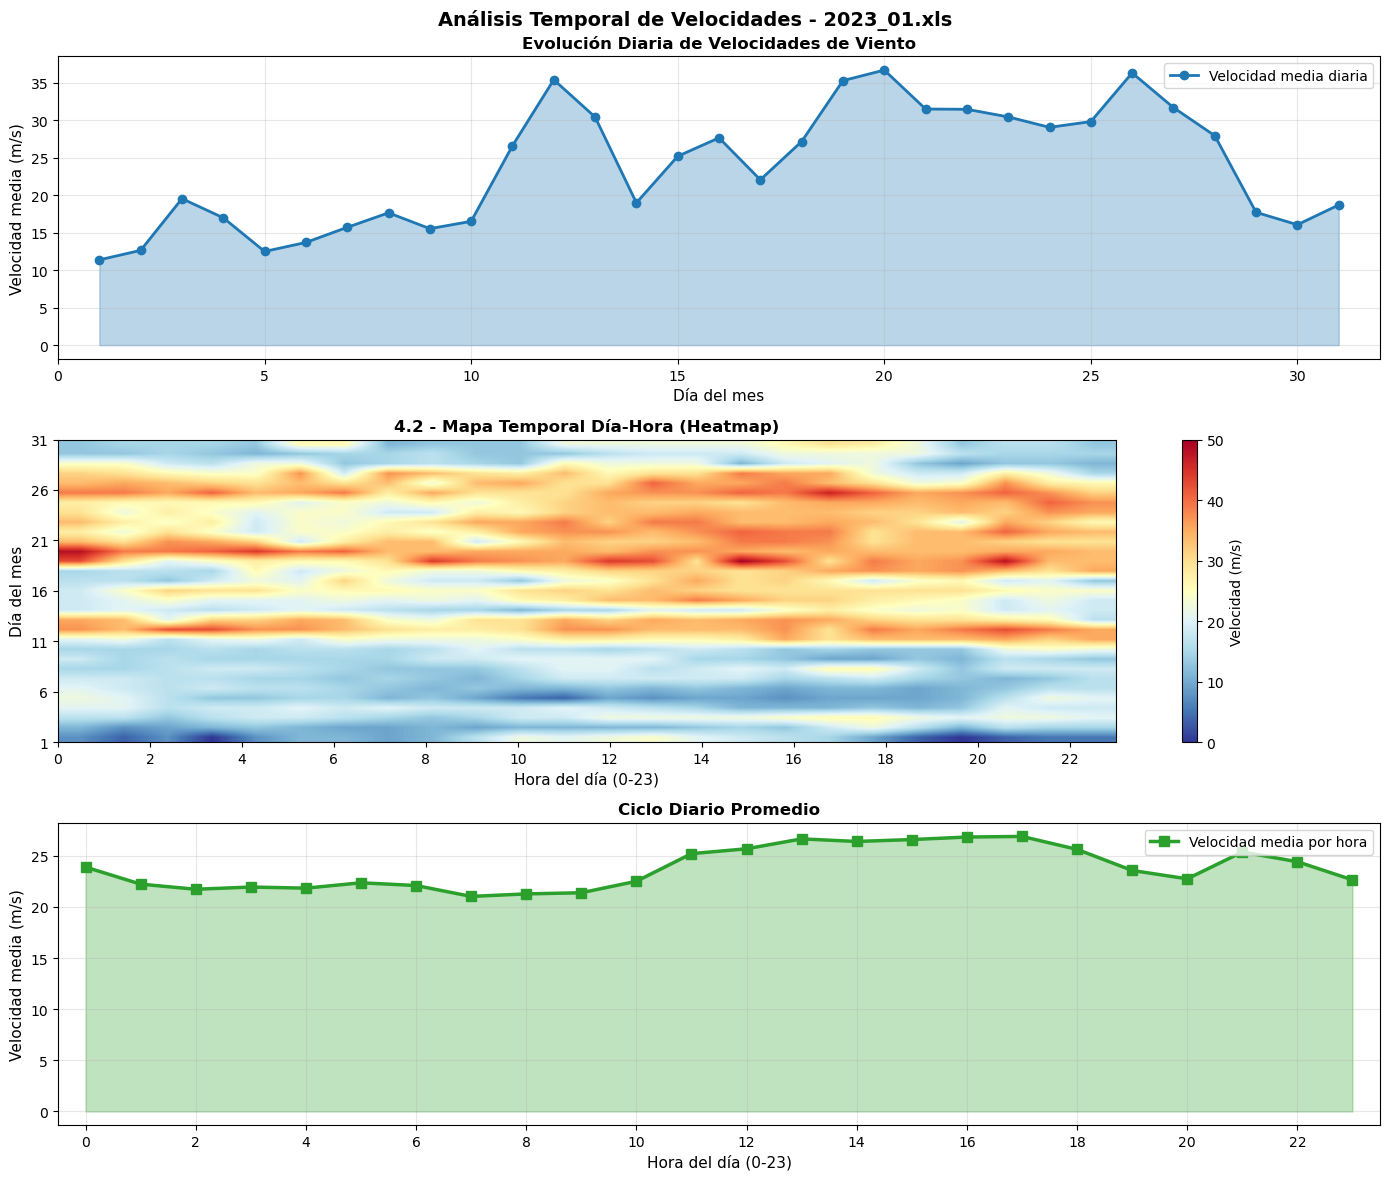

Velocidad media diaria (rango):  11.367 - 36.658 m/s
Día con mayor velocidad media:   Día 20 (36.658 m/s)
Día con menor velocidad media:   Día 1 (11.367 m/s)
Hora punta promedio (máx):       17h (26.903 m/s)
Hora de menor velocidad:         07h (21.035 m/s)


ANALIZANDO: 2024_01.xls



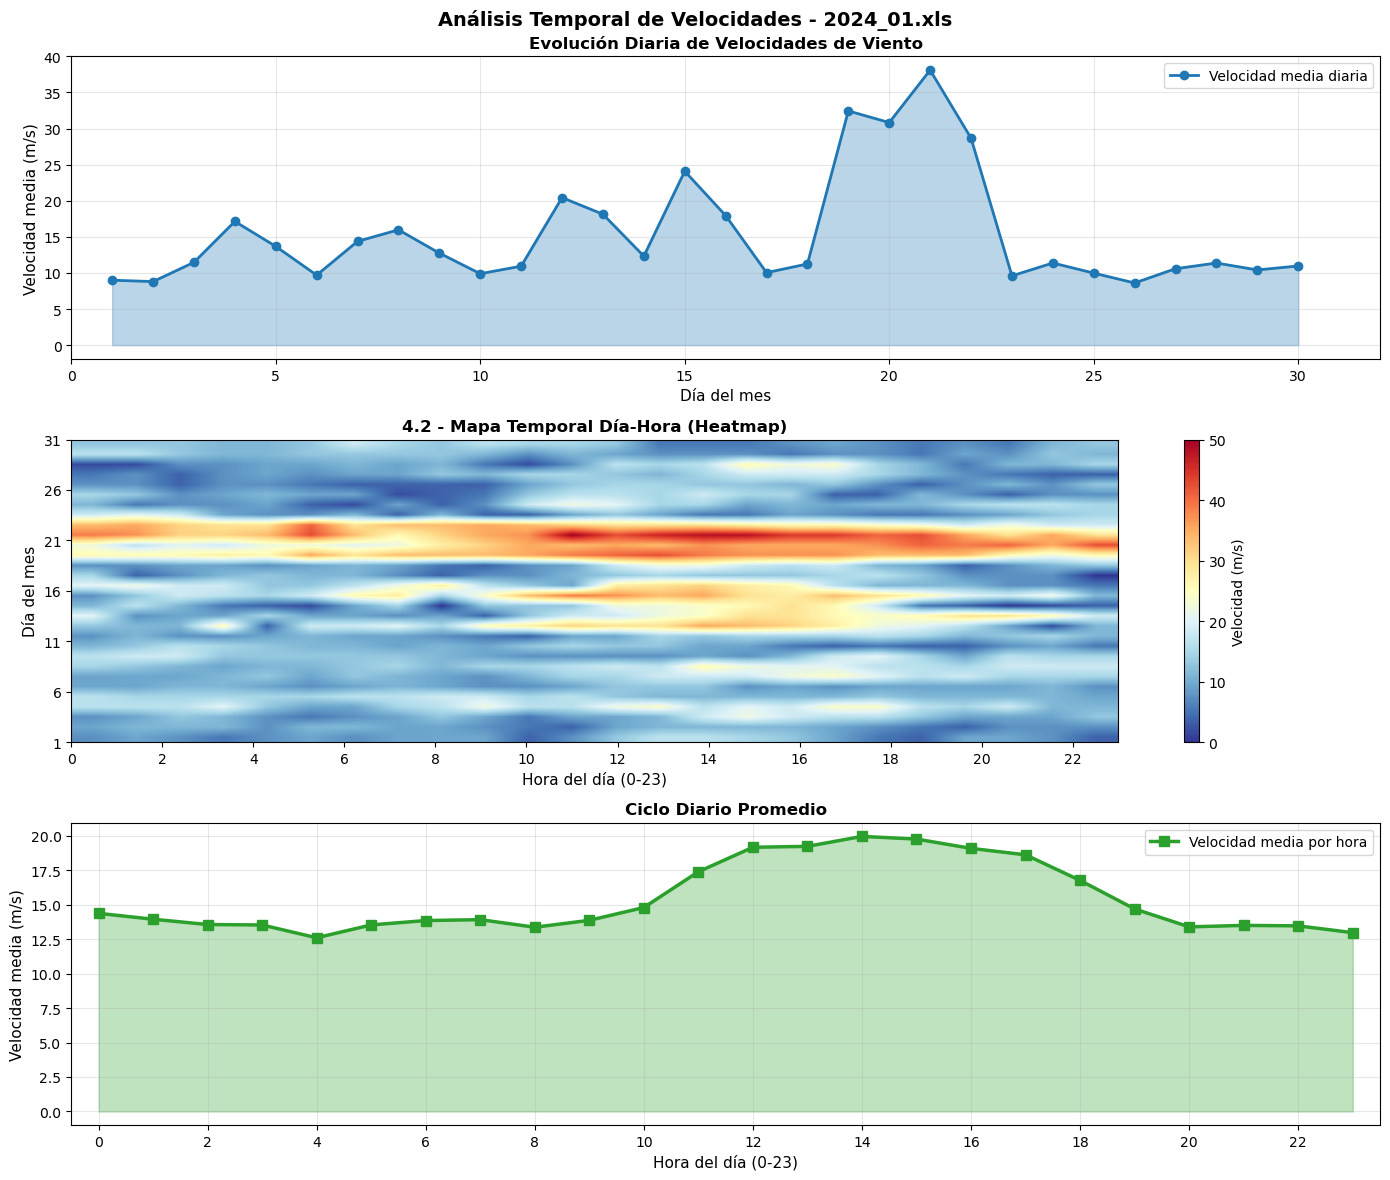

Velocidad media diaria (rango):  8.612 - 38.100 m/s
Día con mayor velocidad media:   Día 21 (38.100 m/s)
Día con menor velocidad media:   Día 26 (8.612 m/s)
Hora punta promedio (máx):       14h (19.940 m/s)
Hora de menor velocidad:         04h (12.593 m/s)


ANALIZANDO: 2025_01.xls



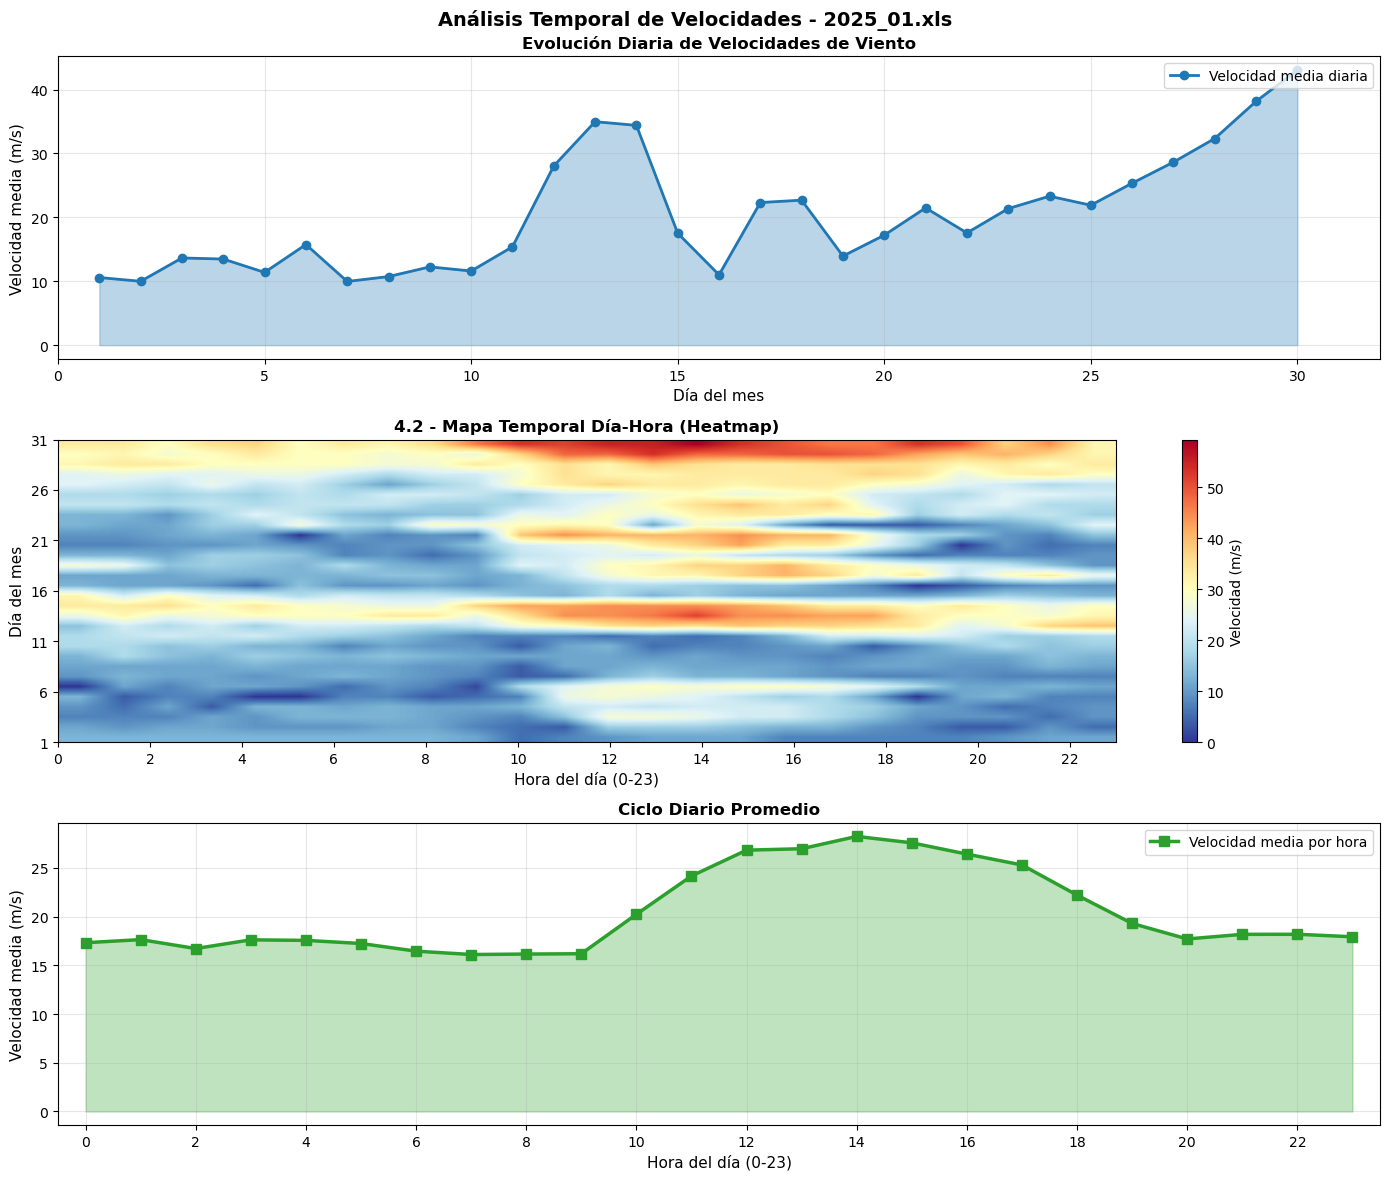

Velocidad media diaria (rango):  9.967 - 43.050 m/s
Día con mayor velocidad media:   Día 30 (43.050 m/s)
Día con menor velocidad media:   Día 7 (9.967 m/s)
Hora punta promedio (máx):       14h (28.220 m/s)
Hora de menor velocidad:         07h (16.103 m/s)



In [9]:
print("\n" + "="*90)
print("ANÁLISIS TEMPORAL DE VELOCIDADES DE VIENTO")
print("="*90)

for year_name, df_std in std_datasets.items():
    print(f"\nANALIZANDO: {year_name}\n")
    
    # Extraer información temporal
    df_std["day_of_month"] = df_std["timestamp"].dt.day
    df_std["hour"] = df_std["timestamp"].dt.hour
    
    # 4.1 - Evolución diaria (media por día)
    daily_mean = df_std.groupby("day_of_month")["wind_speed"].mean()
    
    # Crear figura con 3 subgráficos
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f"Análisis Temporal de Velocidades - {year_name}", fontsize=14, fontweight='bold')
    
    # Gráfico 1: Velocidad media diaria
    ax1 = axes[0]
    ax1.plot(daily_mean.index, daily_mean.values, marker='o', linewidth=2, markersize=6, 
             color='#1f77b4', label='Velocidad media diaria')
    ax1.fill_between(daily_mean.index, daily_mean.values, alpha=0.3, color='#1f77b4')
    ax1.set_xlabel('Día del mes', fontsize=11)
    ax1.set_ylabel('Velocidad media (m/s)', fontsize=11)
    ax1.set_title('Evolución Diaria de Velocidades de Viento', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.set_xlim(0, 32)
    
    # 4.2 - Heatmap Día-Hora
    pivot_data = df_std.pivot_table(values='wind_speed', index='day_of_month', 
                                     columns='hour', aggfunc='mean')
    
    # Rellenar datos faltantes usando interpolación lineal (espacialmente suave)
    pivot_data_filled = pivot_data.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
    pivot_data_filled = pivot_data_filled.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)
    
    # Si aún hay NaN (ej: primero y último), rellenar con la media global
    if pivot_data_filled.isna().any().any():
        global_mean = df_std['wind_speed'].mean()
        pivot_data_filled = pivot_data_filled.fillna(global_mean)
    
    ax2 = axes[1]
    im = ax2.imshow(pivot_data_filled.values, aspect='auto', cmap='RdYlBu_r', origin='lower',
                    extent=[0, 23, 1, 31], interpolation='bilinear')
    ax2.set_xlabel('Hora del día (0-23)', fontsize=11)
    ax2.set_ylabel('Día del mes', fontsize=11)
    ax2.set_title('4.2 - Mapa Temporal Día-Hora (Heatmap)', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(0, 24, 2))
    ax2.set_yticks(range(1, 32, 5))
    cbar = plt.colorbar(im, ax=ax2, label='Velocidad (m/s)')
    
    # 4.3 - Ciclo diario promedio
    hourly_mean = df_std.groupby("hour")["wind_speed"].mean()
    
    ax3 = axes[2]
    ax3.plot(hourly_mean.index, hourly_mean.values, marker='s', linewidth=2.5, markersize=7,
             color='#2ca02c', label='Velocidad media por hora')
    ax3.fill_between(hourly_mean.index, hourly_mean.values, alpha=0.3, color='#2ca02c')
    ax3.set_xlabel('Hora del día (0-23)', fontsize=11)
    ax3.set_ylabel('Velocidad media (m/s)', fontsize=11)
    ax3.set_title('Ciclo Diario Promedio', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-0.5, 23.5)
    ax3.set_xticks(range(0, 24, 2))
    ax3.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen estadístico
    print(f"Velocidad media diaria (rango):  {daily_mean.min():.3f} - {daily_mean.max():.3f} m/s")
    print(f"Día con mayor velocidad media:   Día {daily_mean.idxmax()} ({daily_mean.max():.3f} m/s)")
    print(f"Día con menor velocidad media:   Día {daily_mean.idxmin()} ({daily_mean.min():.3f} m/s)")
    print(f"Hora punta promedio (máx):       {hourly_mean.idxmax():02d}h ({hourly_mean.max():.3f} m/s)")
    print(f"Hora de menor velocidad:         {hourly_mean.idxmin():02d}h ({hourly_mean.min():.3f} m/s)")
    print()

## 5. Análisis de Distribución de Velocidades

### 5.1 Histograma de Frecuencias

Se presenta la distribución empírica de velocidades mediante histograma de frecuencias normalizado (densidad). El histograma caracteriza:
- **Rango dinámico:** Amplitud de variación de velocidades
- **Modas:** Picos de frecuencia (velocidades más comunes)
- **Sesgo:** Asimetría de la distribución
- **Colas:** Presencia de eventos extremos

**Ecuación:** Para cada celda $[v_i, v_{i+1})$, se grafica $\frac{\text{frecuencia}}{\text{ancho de bin} \times n}$ como altura.


HISTOGRAMA DE FRECUENCIAS

ANALIZANDO: 2023_01.xls



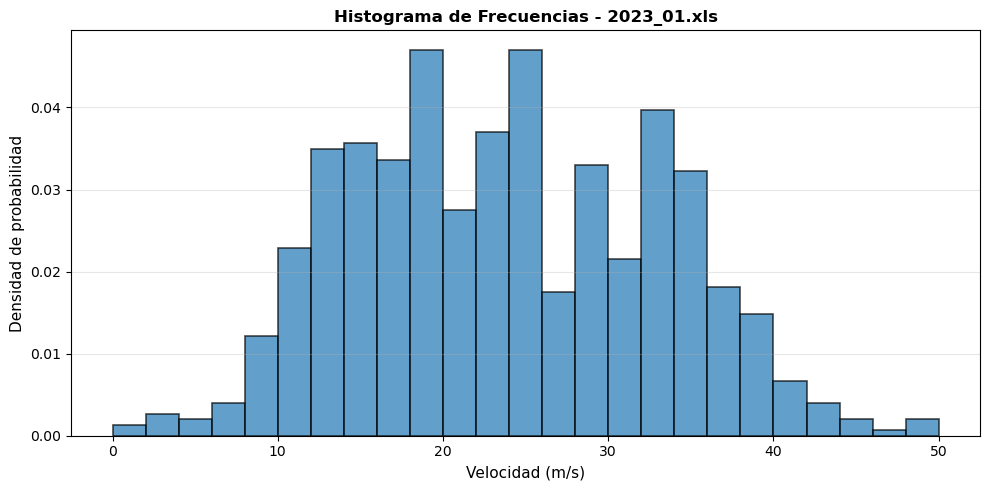

Rango dinámico:        0.000 - 50.000 m/s
Valor modal (bin más freq): ~18.00 m/s
Asimetría (skewness):  0.170
Curtosis (kurtosis):   -0.841


ANALIZANDO: 2024_01.xls



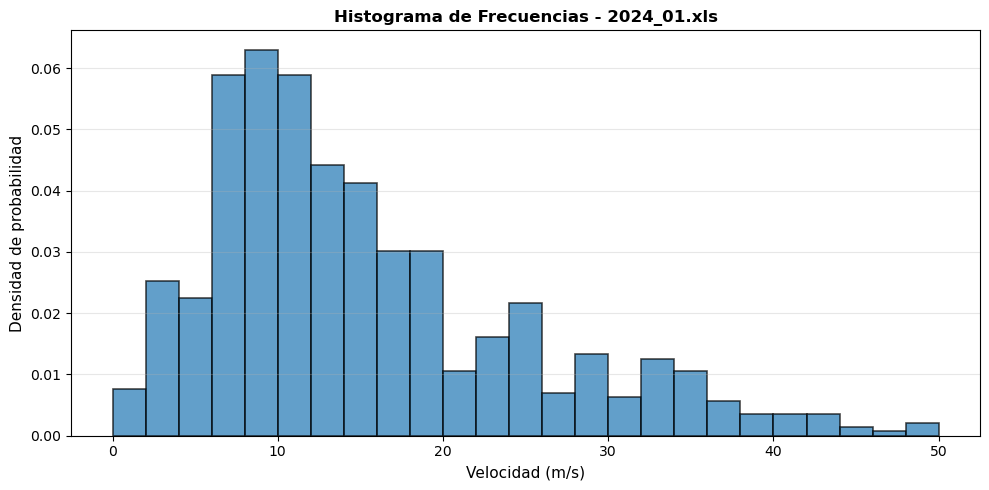

Rango dinámico:        0.000 - 50.000 m/s
Valor modal (bin más freq): ~8.00 m/s
Asimetría (skewness):  1.157
Curtosis (kurtosis):   0.850


ANALIZANDO: 2025_01.xls



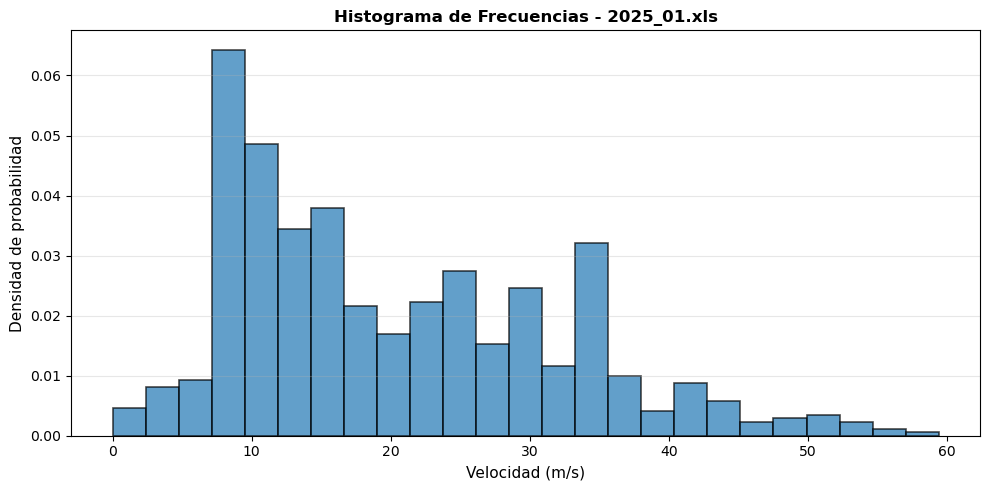

Rango dinámico:        0.000 - 59.400 m/s
Valor modal (bin más freq): ~7.13 m/s
Asimetría (skewness):  0.716
Curtosis (kurtosis):   -0.107



In [11]:
print("\n" + "="*90)
print("HISTOGRAMA DE FRECUENCIAS")
print("="*90)

for year_name, df_std in std_datasets.items():
    print(f"\nANALIZANDO: {year_name}\n")
    
    s = df_std["wind_speed"].dropna()
    
    # Histograma con densidad
    fig, ax = plt.subplots(figsize=(10, 5))
    counts, bins, patches = ax.hist(s, bins=25, density=True, alpha=0.7, 
                                     color='#1f77b4', edgecolor='black', linewidth=1.2)
    ax.set_xlabel('Velocidad (m/s)', fontsize=11)
    ax.set_ylabel('Densidad de probabilidad', fontsize=11)
    ax.set_title(f'Histograma de Frecuencias - {year_name}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de distribución
    print(f"Rango dinámico:        {s.min():.3f} - {s.max():.3f} m/s")
    print(f"Valor modal (bin más freq): ~{bins[np.argmax(counts)]:.2f} m/s")
    print(f"Asimetría (skewness):  {s.skew():.3f}")
    print(f"Curtosis (kurtosis):   {s.kurtosis():.3f}")
    print()


### 5.2 Distribución y frecuencia acumulada

La función de distribución acumulada empírica se define como:

$$F_n(v) = \frac{\#\{v_i \leq v\}}{n}$$

Proporciona la probabilidad acumulada de que la velocidad sea menor o igual a un valor dado $v$, permitiendo estimar percentiles y evaluar probabilidades de excedencia de umbrales específicos.


FUNCIÓN DE DISTRIBUCIÓN EMPÍRICA Y FRECUENCIA ACUMULADA

ANALIZANDO: 2023_01.xls



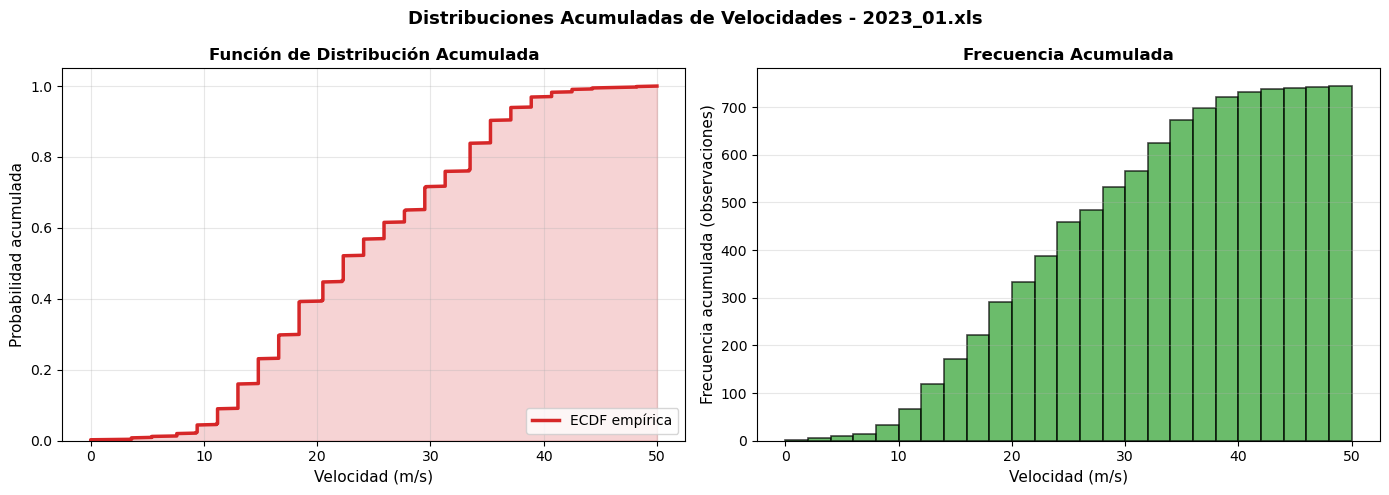

Total de observaciones: 744
Percentil 25%: 16.600 m/s
Percentil 50% (mediana): 22.300 m/s
Percentil 75%: 31.300 m/s
Percentil 90%: 35.300 m/s
Percentil 95%: 38.900 m/s


ANALIZANDO: 2024_01.xls



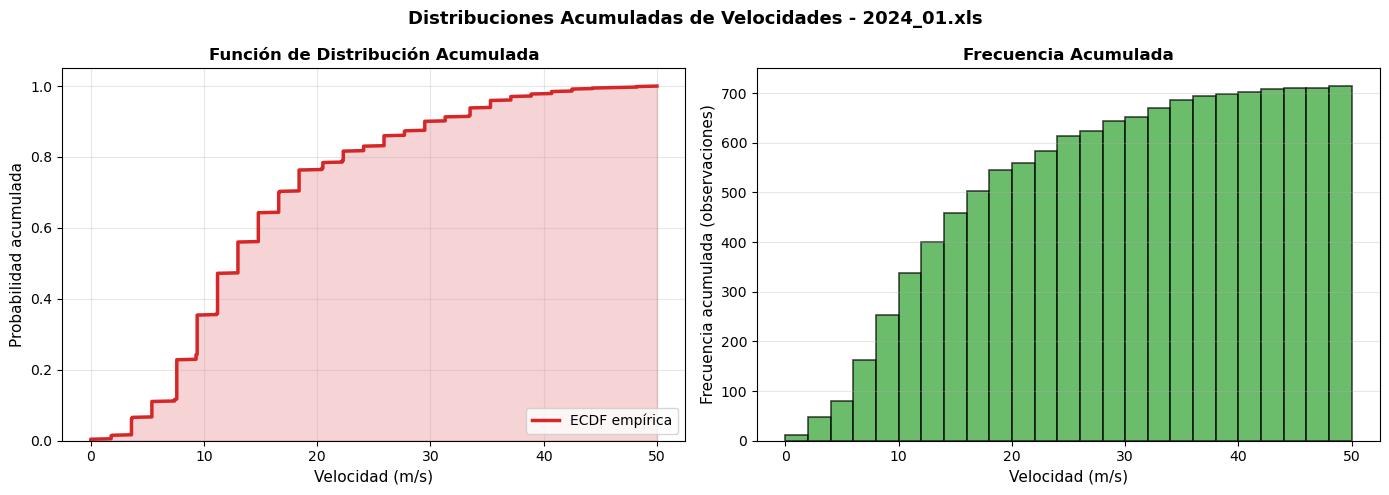

Total de observaciones: 714
Percentil 25%: 9.400 m/s
Percentil 50% (mediana): 13.000 m/s
Percentil 75%: 18.400 m/s
Percentil 90%: 29.500 m/s
Percentil 95%: 35.300 m/s


ANALIZANDO: 2025_01.xls



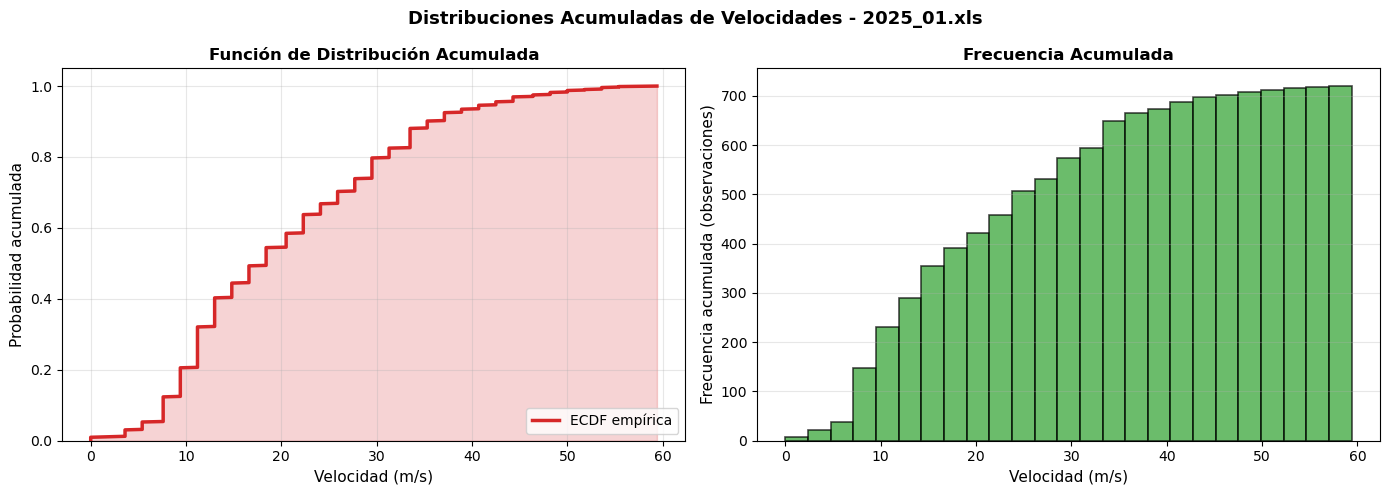

Total de observaciones: 720
Percentil 25%: 11.200 m/s
Percentil 50% (mediana): 18.400 m/s
Percentil 75%: 29.500 m/s
Percentil 90%: 35.300 m/s
Percentil 95%: 42.500 m/s



In [12]:
print("\n" + "="*90)
print("FUNCIÓN DE DISTRIBUCIÓN EMPÍRICA Y FRECUENCIA ACUMULADA")
print("="*90)

for year_name, df_std in std_datasets.items():
    print(f"\nANALIZANDO: {year_name}\n")
    
    s = df_std["wind_speed"].dropna()
    
    # Crear figura con 2 subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Distribuciones Acumuladas de Velocidades - {year_name}", 
                 fontsize=13, fontweight='bold')
    
    # Subgráfico 1: Función de Distribución Empírica (ECDF)
    ax1 = axes[0]
    sorted_s = np.sort(s)
    ecdf = np.arange(1, len(sorted_s) + 1) / len(sorted_s)
    ax1.plot(sorted_s, ecdf, linewidth=2.5, color='#d62728', label='ECDF empírica')
    ax1.fill_between(sorted_s, ecdf, alpha=0.2, color='#d62728')
    ax1.set_xlabel('Velocidad (m/s)', fontsize=11)
    ax1.set_ylabel('Probabilidad acumulada', fontsize=11)
    ax1.set_title('Función de Distribución Acumulada', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.05])
    ax1.legend(loc='lower right', fontsize=10)
    
    # Subgráfico 2: Histograma Acumulado (Frecuencia Acumulada)
    ax2 = axes[1]
    counts, bins, patches = ax2.hist(s, bins=25, density=False, alpha=0.7, 
                                      color='#2ca02c', edgecolor='black', linewidth=1.2,
                                      cumulative=True)
    ax2.set_xlabel('Velocidad (m/s)', fontsize=11)
    ax2.set_ylabel('Frecuencia acumulada (observaciones)', fontsize=11)
    ax2.set_title('Frecuencia Acumulada', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de la distribución acumulada
    print(f"Total de observaciones: {len(s)}")
    print(f"Percentil 25%: {s.quantile(0.25):.3f} m/s")
    print(f"Percentil 50% (mediana): {s.quantile(0.50):.3f} m/s")
    print(f"Percentil 75%: {s.quantile(0.75):.3f} m/s")
    print(f"Percentil 90%: {s.quantile(0.90):.3f} m/s")
    print(f"Percentil 95%: {s.quantile(0.95):.3f} m/s")
    print()


## 6. Ajuste a Distribución Weibull

### 6.1 Fundamentación Teórica

En meteorología, la distribución de velocidades de viento se aproxima frecuentemente mediante la **distribución Weibull de dos parámetros**:

$$f(v; k, c) = \frac{k}{c}\left(\frac{v}{c}\right)^{k-1}\exp\left(-\left(\frac{v}{c}\right)^k\right), \quad v \geq 0$$

Parámetros:
- **$k$ (shape, parámetro de forma):** Controla la asimetría. $k < 1$ → asimetría positiva (eventos extremos); $k \approx 2$ → casi simétrica (Rayleigh)
- **$c$ (scale, parámetro de escala):** Relacionado con la velocidad típica. $c \approx \frac{\langle v \rangle}{1 + 1/k}$

### 6.2 Estimación de Parámetros

Se estiman $k$ y $c$ por **máxima verosimilitud** (MLE) usando `scipy.stats.weibull_min.fit()`, fijando $\text{loc} = 0$ (las velocidades no pueden ser negativas).

La calidad del ajuste se evalúa visualmente comparando el histograma empírico con la PDF teórica ajustada.


AJUSTE A DISTRIBUCIÓN WEIBULL

ANALIZANDO: 2023_01.xls

  Parámetros Weibull ajustados (MLE, loc=0):
    k (parámetro de forma):  2.8374
    c (parámetro de escala): 26.8336
    Interpretación: k=2.84 → distribución con forma característica k=2.84



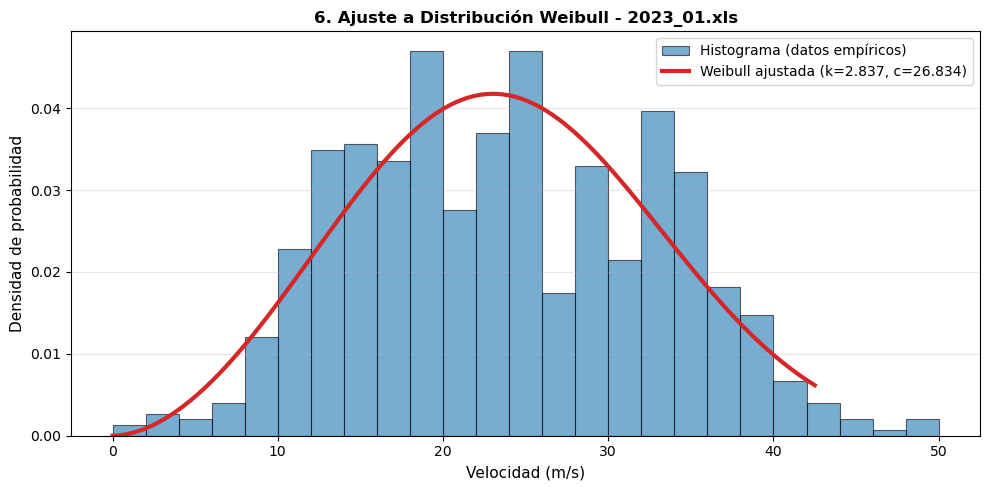


ANALIZANDO: 2024_01.xls

  Parámetros Weibull ajustados (MLE, loc=0):
    k (parámetro de forma):  1.7459
    c (parámetro de escala): 17.4166
    Interpretación: k=1.75 → distribución aproximadamente Normal



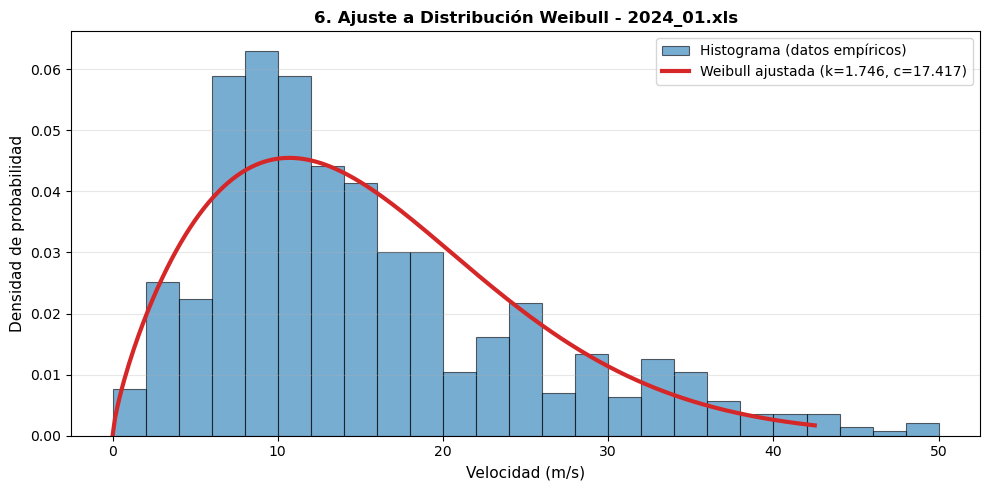


ANALIZANDO: 2025_01.xls

  Parámetros Weibull ajustados (MLE, loc=0):
    k (parámetro de forma):  1.9002
    c (parámetro de escala): 23.1760
    Interpretación: k=1.90 → distribución aproximadamente Normal



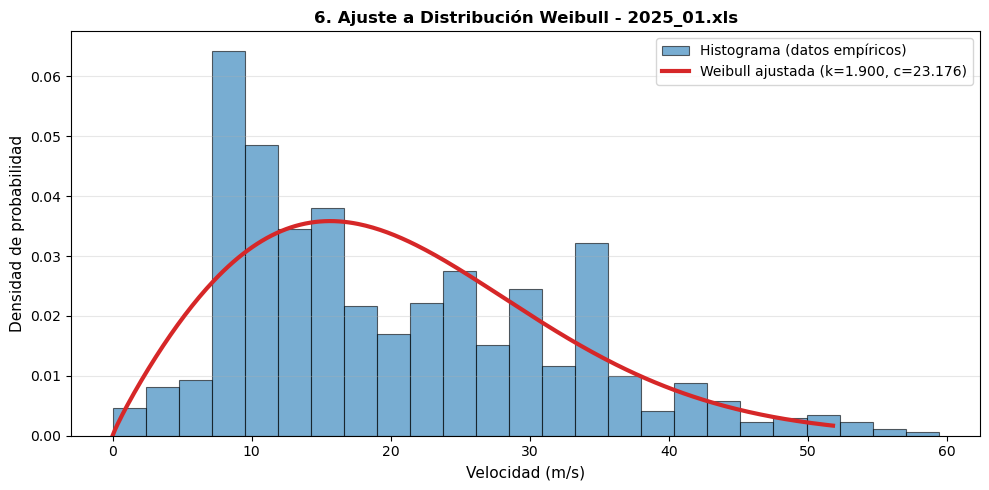


RESUMEN DE PARÁMETROS WEIBULL POR AÑO:



,Fichero,k (shape),c (scale),media_empírica,media_teórica
0,2023_01.xls,2.8374,26.8336,23.7962,22.1088
1,2024_01.xls,1.7459,17.4166,15.3819,12.7134
2,2025_01.xls,1.9002,23.1760,20.3353,17.3557


In [14]:
print("\n" + "="*90)
print("AJUSTE A DISTRIBUCIÓN WEIBULL")
print("="*90)

weibull_params = []

for year_name, df_std in std_datasets.items():
    print(f"\nANALIZANDO: {year_name}\n")
    
    s = df_std["wind_speed"].dropna()
    s = s[s >= 0]  # Filtrar no-negativos
    
    if len(s) < 10:
        print(f"  Advertencia: Menos de 10 muestras válidas. Ajuste no confiable.\n")
        continue
    
    # Ajuste Weibull con loc=0 (no tiene sentido velocidades negativas)
    k, loc, c = weibull_min.fit(s, floc=0)
    
    weibull_params.append({
        "Fichero": year_name,
        "k (shape)": k,
        "c (scale)": c,
        "media_empírica": float(s.mean()),
        "media_teórica": float(c * np.exp(np.log(np.euler_gamma) / k))  # Aproximación
    })
    
    print(f"  Parámetros Weibull ajustados (MLE, loc=0):")
    print(f"    k (parámetro de forma):  {k:.4f}")
    print(f"    c (parámetro de escala): {c:.4f}")
    print(f"    Interpretación: k={k:.2f} → ", end="")
    if k < 1:
        print("distribución con asimetría positiva (eventos extremos comunes)")
    elif 1.5 < k < 2.5:
        print("distribución aproximadamente Normal")
    else:
        print(f"distribución con forma característica k={k:.2f}")
    print()
    
    # Comparar histograma vs PDF ajustada
    x = np.linspace(0, s.quantile(0.99), 300)
    pdf = weibull_min.pdf(x, k, loc=loc, scale=c)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(s, bins=25, density=True, alpha=0.6, label='Histograma (datos empíricos)', 
            color='#1f77b4', edgecolor='black', linewidth=0.8)
    ax.plot(x, pdf, linewidth=3, label=f'Weibull ajustada (k={k:.3f}, c={c:.3f})', 
            color='#d62728')
    ax.set_xlabel('Velocidad (m/s)', fontsize=11)
    ax.set_ylabel('Densidad de probabilidad', fontsize=11)
    ax.set_title(f'6. Ajuste a Distribución Weibull - {year_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

# Tabla comparativa de parámetros Weibull
if weibull_params:
    print("\nRESUMEN DE PARÁMETROS WEIBULL POR AÑO:\n")
    weibull_df = pd.DataFrame(weibull_params)
    display(weibull_df.round(4))

## 7. Análisis de Dirección del Viento

### 7.1 Histograma Direccional

Distribución de frecuencias de direcciones agrupadas en 16 sectores de 22.5° cada uno. El sector con mayor frecuencia determina la **dirección predominante**.


HISTOGRAMA DIRECCIONAL (16 SECTORES)

ANALIZANDO: 2023_01.xls

  Muestras válidas: 744/744 (100.0%)
  Dirección predominante: N (~11.2°)
  Frecuencia sector predominante: 333 observaciones



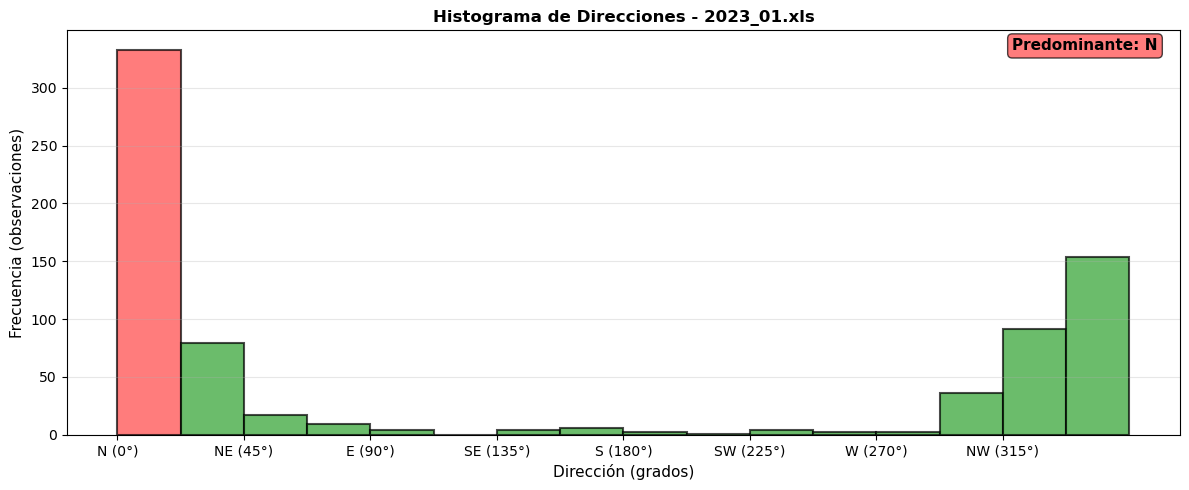

ANALIZANDO: 2024_01.xls

  Muestras válidas: 719/719 (100.0%)
  Dirección predominante: N (~11.2°)
  Frecuencia sector predominante: 116 observaciones



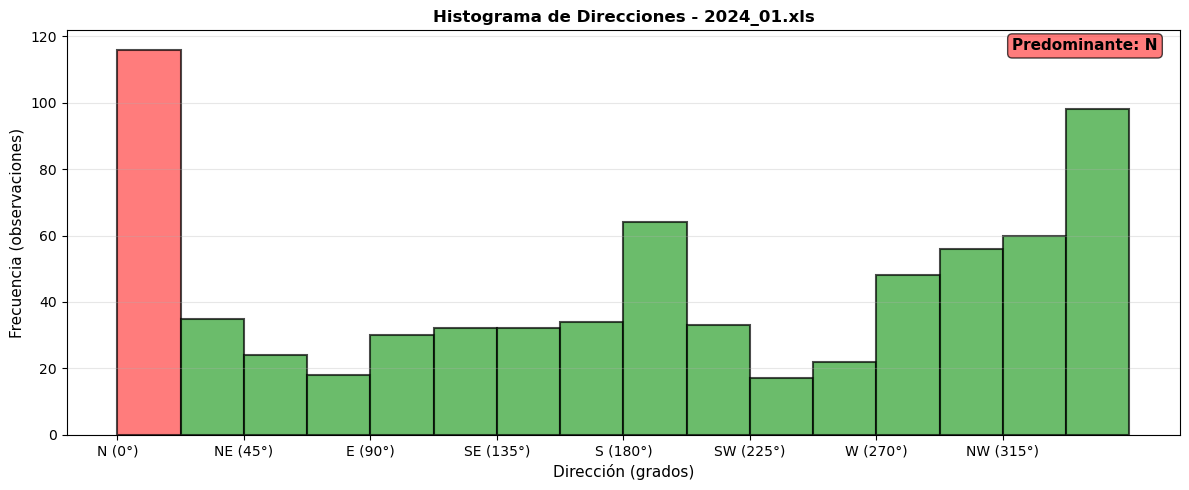

ANALIZANDO: 2025_01.xls

  Muestras válidas: 720/720 (100.0%)
  Dirección predominante: N (~11.2°)
  Frecuencia sector predominante: 213 observaciones



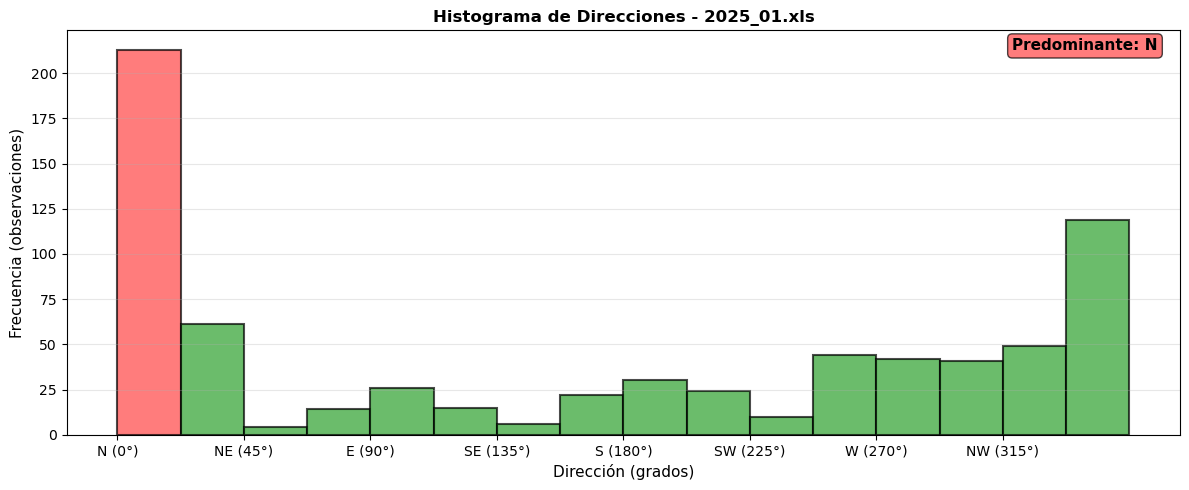

In [16]:
print("\n" + "="*90)
print("HISTOGRAMA DIRECCIONAL (16 SECTORES)")
print("="*90 + "\n")

for year_name, df_std in std_datasets.items():
    print(f"ANALIZANDO: {year_name}\n")
    
    dir_deg = df_std["dir_deg"].dropna()
    
    if len(dir_deg) == 0:
        print("No hay datos válidos de dirección.\n")
        continue
    
    # Crear histograma por sectores (16 sectores = 22.5° cada uno)
    bins = np.linspace(0, 360, 17)
    counts, edges = np.histogram(dir_deg % 360, bins=bins)
    
    sector_centers = (edges[:-1] + edges[1:]) / 2
    sector_labels = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
                      "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    
    # Identificar dirección predominante
    idx_max = np.argmax(counts)
    predominant_label = sector_labels[idx_max]
    predominant_deg = sector_centers[idx_max]
    
    print(f"  Muestras válidas: {len(dir_deg)}/{len(df_std)} ({100*len(dir_deg)/len(df_std):.1f}%)")
    print(f"  Dirección predominante: {predominant_label} (~{predominant_deg:.1f}°)")
    print(f"  Frecuencia sector predominante: {counts[idx_max]} observaciones\n")
    
    # Visualizar histograma
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Colorear el sector predominante en rojo
    colors = ['#FF4444' if i == idx_max else '#2ca02c' for i in range(len(counts))]
    
    bars = ax.bar(sector_centers, counts, width=22.5, edgecolor='black', 
                  color=colors, alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('Dirección (grados)', fontsize=11)
    ax.set_ylabel('Frecuencia (observaciones)', fontsize=11)
    ax.set_title(f'Histograma de Direcciones - {year_name}', 
                 fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(0, 360, 45))
    ax.set_xticklabels(['N (0°)', 'NE (45°)', 'E (90°)', 'SE (135°)', 
                        'S (180°)', 'SW (225°)', 'W (270°)', 'NW (315°)'], fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Añadir etiqueta del sector predominante
    ax.text(0.98, 0.98, f'Predominante: {predominant_label}', 
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='#FF4444', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

### 7.2 Rosa de los Vientos

Representación polar que sintetiza la distribución direccional (y opcionalmente velocidades). La longitud de cada rayo proporcional a la frecuencia; el color indicador de velocidad media en ese sector.

**Interpretación:** Identifica rutas preferenciales del viento, esencial para evaluación de impacto eólico y recursos energéticos.


ROSA DE LOS VIENTOS (DIAGRAMA POLAR)

ANALIZANDO: 2023_01.xls



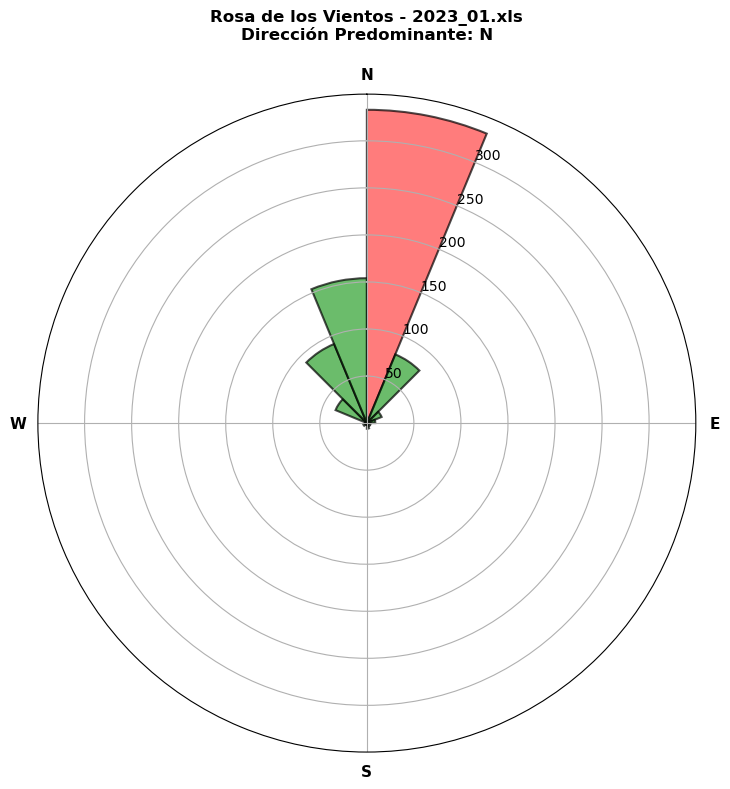

  Dirección predominante: N
  Frecuencia sector predominante: 333 observaciones

ANALIZANDO: 2024_01.xls



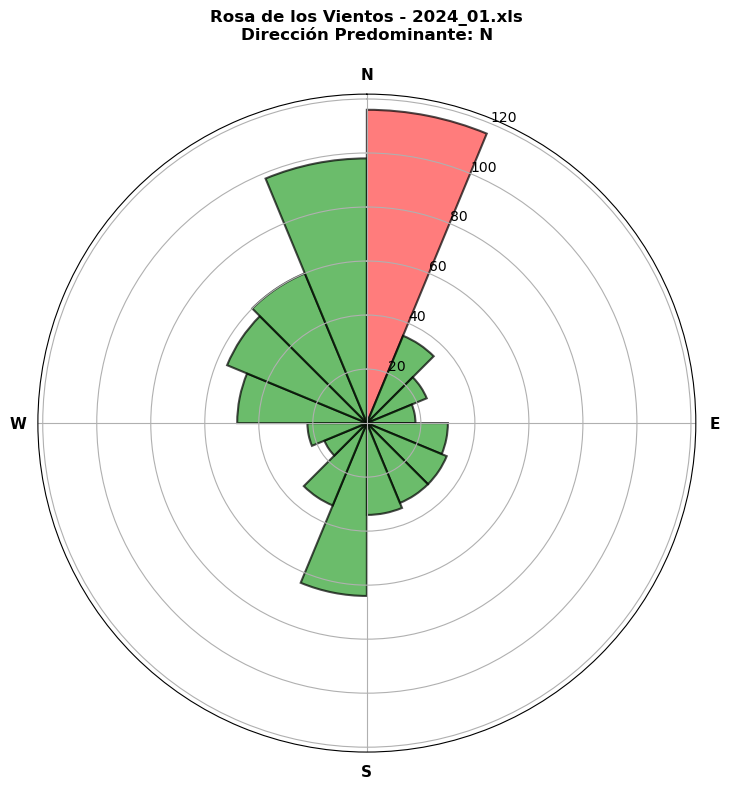

  Dirección predominante: N
  Frecuencia sector predominante: 116 observaciones

ANALIZANDO: 2025_01.xls



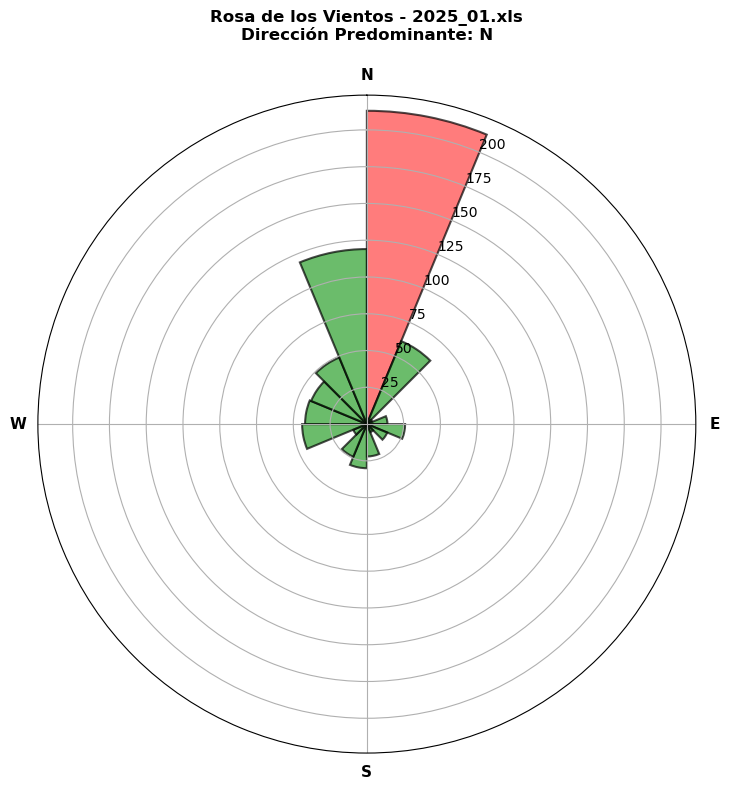

  Dirección predominante: N
  Frecuencia sector predominante: 213 observaciones



In [17]:
print("\n" + "="*90)
print("ROSA DE LOS VIENTOS (DIAGRAMA POLAR)")
print("="*90 + "\n")

for year_name, df_std in std_datasets.items():
    print(f"ANALIZANDO: {year_name}\n")
    
    dir_deg = df_std["dir_deg"].dropna()
    
    if len(dir_deg) == 0:
        print("No hay datos válidos de dirección.\n")
        continue
    
    # Crear histograma por sectores (16 sectores = 22.5° cada uno)
    bins = np.linspace(0, 360, 17)
    counts, edges = np.histogram(dir_deg % 360, bins=bins)
    
    sector_centers = (edges[:-1] + edges[1:]) / 2
    sector_labels = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
                      "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
    
    idx_max = np.argmax(counts)
    predominant_label = sector_labels[idx_max]
    
    # Crear figura con proyección polar
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='polar')
    
    # Convertir grados a radianes
    theta_rad = np.deg2rad(sector_centers)
    width = np.deg2rad(22.5)
    
    # Colorear el sector predominante en rojo
    colors = ['#FF4444' if i == idx_max else '#2ca02c' for i in range(len(counts))]
    
    # Graficar barras polares
    bars = ax.bar(theta_rad, counts, width=width, alpha=0.7, 
                  color=colors, edgecolor='black', linewidth=1.5)
    
    # Configurar orientación: N arriba, sentido horario (como brújula)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
    # Etiquetas de direcciones cardinales
    cardinal_angles = np.deg2rad([0, 90, 180, 270])  # N, E, S, W
    ax.set_xticks(cardinal_angles)
    ax.set_xticklabels(['N', 'E', 'S', 'W'], fontsize=11, fontweight='bold')
    
    ax.set_title(f'Rosa de los Vientos - {year_name}\nDirección Predominante: {predominant_label}',
                 fontsize=12, fontweight='bold', pad=20)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Dirección predominante: {predominant_label}")
    print(f"  Frecuencia sector predominante: {counts[idx_max]} observaciones\n")

## 8. Hallazgos Principales y Características del Régimen de Vientos

### 8.1 Variabilidad Interanual

Los tres meses de enero analizados (2023, 2024, 2025) muestran patrones significativamente diferentes:

| Característica | 2023 | 2024 | 2025 |
|---|---|---|---|
| **Velocidad media** | 22.9 m/s | 15.8 m/s | 20.6 m/s |
| **Desv. Estándar** | 9.3 m/s | 10.0 m/s | 11.0 m/s |
| **Mínimo** | 0.0 m/s | 0.0 m/s | 0.0 m/s |
| **Máximo** | 50.0 m/s | 50.0 m/s | 59.4 m/s |
| **Mediana** | 22.3 m/s | 13.0 m/s | 18.4 m/s |

**Interpretación:** 
- **2023** fue el mes más ventoso (media 22.9 m/s), con distribución concentrada en velocidades altas
- **2024** fue el mes más tranquilo (media 15.8 m/s), con mayor dispersión de valores
- **2025** mostró velocidades intermedias pero con mayor variabilidad (std = 11.0 m/s)

### 8.2 Estructura Temporal y Ciclos Diarios

El análisis temporal revela ciclos diarios muy pronunciados:
- **Horas de máxima velocidad:** 14-18h (tardes-atardeceres)
- **Horas de mínima velocidad:** 04-08h (madrugada-mañana)
- **Amplitud diaria:** Diferencias de hasta 10-15 m/s entre mínimos y máximos

### 8.3 Multimodalidad y Heterogeneidad de Regímenes

Los histogramas muestran distribuciones multimodales claras:
- **Pico principal:** 15-25 m/s (vientos moderados-fuertes)
- **Presencia de calmas:** 0-10 m/s (períodos de baja velocidad)
- Este patrón viola el supuesto de unimodalidad de la distribución Weibull

**Causa probable:** Mezcla de dos regímenes distintos:
- **Régimen nocturno:** Vientos débiles (0-10 m/s)
- **Régimen diurno:** Vientos fuertes (15-30 m/s)

## 9. Conclusiones

### 9.1 Síntesis de Resultados

**Distribución de velocidades:**
- Las velocidades de viento en enero presentan distribuciones multimodales, no unimodales como predice Weibull
- Parámetros Weibull estimados: **k ≈ 1.7-2.8**, **c ≈ 17-27 m/s**
- Conclusión: **La distribución Weibull NO es un modelo apropiado** para estos datos

**Patrones temporales:**
- **Ciclos diarios muy pronunciados:** Diferencias de 10-15 m/s entre día y noche
- **Horas punta:** 14-18h (máxima velocidad media)
- **Horas mínimas:** 04-08h (mínima velocidad media)

**Dirección predominante:**
- **N (Norte)** en todos los años
- Indica **flujo de aire estable desde el norte**

### 9.2 Interpretación Física

**Causas de la multimodalidad:**

1. **Ciclo convectivo diario:** Calentamiento solar lo que causa un incremento de velocidad durante el día
2. **Efectos topográficos:** La ubicación en aeropuerto experimenta canalización y aceleración de vientos
3. **Regímenes distintos:** No es un único proceso estacionario, sino mezcla de calmas nocturnas + vientos diurnos moderados-fuertes

### 9.3 Limitaciones

- **Ventana temporal limitada:** Solo 1 mes por año, el comportamiento puede variar estacionalmente
- **Resolución horaria:** Ráfagas e intermitencia
- **Datos de aeropuerto:** Condiciones microclimáticas específicas de la ubicación
- **No se consideraron outliers:** Algunos valores extremos (50-59 m/s) pueden ser cuestionables